<a href="https://colab.research.google.com/github/williamdarryl22/Face-landmarks-detection/blob/main/C_vision_DARRYL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Face Landmark Detection Project
Using the iBUG 300-W dataset with Dlib / OpenCV

Author: William Darryl Towa Kengne


# 🧠 Face Landmark Detection using the iBUG 300-W Dataset

## Introduction

Facial landmark detection is a key task in computer vision, essential for applications such as facial recognition, emotion analysis, augmented reality, and medical diagnostics. The objective of this project is to identify and localize key points on human faces—such as the eyes, nose, mouth, and jawline—using machine learning techniques.

In this notebook, I use the iBUG 300-W large facial landmark dataset, which contains annotated images with 68 key facial points. The goal is to develop a pipeline that can load the dataset, detect faces, and accurately overlay landmarks using tools like Dlib and OpenCV.

This project demonstrates my understanding of:
- Data preprocessing and visualization in computer vision
- Keypoint detection techniques using pretrained models
- Drawing bounding boxes and landmarks on faces
- Performance evaluation in visual AI tasks

All code was written and executed in Google Colab.


In [1]:
import time
import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import imutils
import matplotlib.image as mpimg
from collections import OrderedDict
from skimage import io, transform
from math import *
import xml.etree.ElementTree as ET

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

##Download the DLIB Dataset

In [2]:
%%capture
if not os.path.exists('/content/ibug_300W_large_face_landmark_dataset'):
    !wget http://dlib.net/files/data/ibug_300W_large_face_landmark_dataset.tar.gz
    !tar -xvzf 'ibug_300W_large_face_landmark_dataset.tar.gz'
    !rm -r 'ibug_300W_large_face_landmark_dataset.tar.gz'

##Visualization

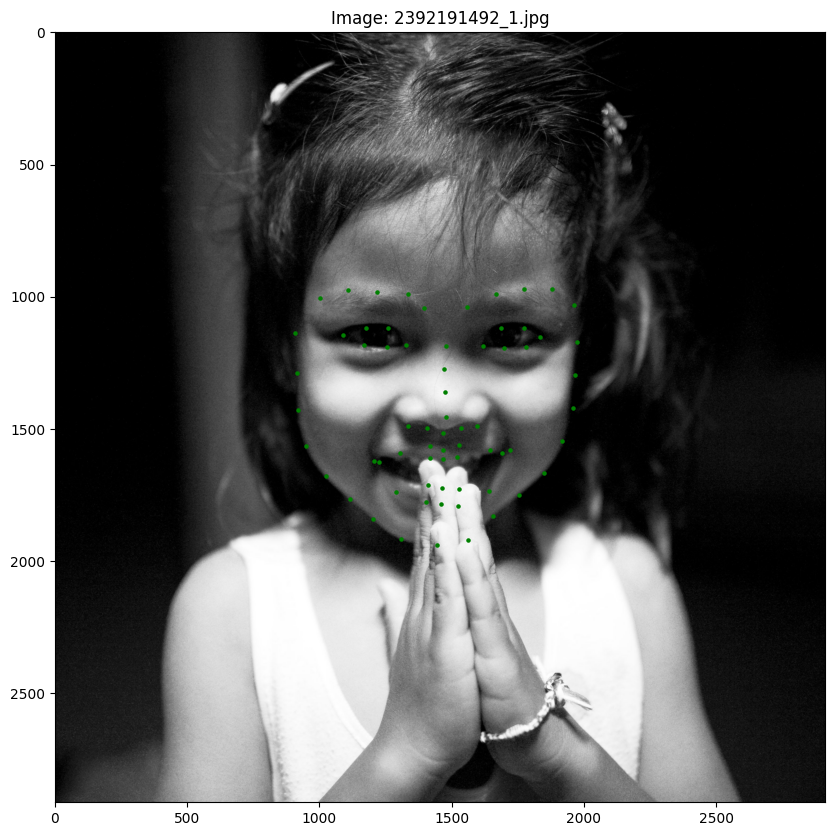

In [3]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from math import floor

# Define the path to the dataset
dataset_path = 'ibug_300W_large_face_landmark_dataset/helen/trainset'

# Get a list of all .pts files in the dataset
pts_files = [f for f in os.listdir(dataset_path) if f.endswith('.pts')]

# Randomly select a .pts file
random_pts_file = random.choice(pts_files)

# Construct the corresponding image file name
random_image_file = random_pts_file.replace('.pts', '.jpg')

# Read the landmarks from the .pts file
with open(os.path.join(dataset_path, random_pts_file), 'r') as file:
    points = file.readlines()[3:-1]

landmarks = []

for point in points:
    x, y = point.split(' ')
    landmarks.append([floor(float(x)), floor(float(y[:-1]))])

landmarks = np.array(landmarks)

# Read and display the corresponding image
plt.figure(figsize=(10, 10))
image = mpimg.imread(os.path.join(dataset_path, random_image_file))
plt.imshow(image)
plt.scatter(landmarks[:, 0], landmarks[:, 1], s=5, c='g')
plt.title(f'Image: {random_image_file}')
plt.show()

You can see that the face covers very less amount of space in the image. If we will use this image in the neural network it will take the background also. So like we prepare a text data we will prepare this image dataset for further exploration.

##Creating Dataset Classes

Now Let’s dig deeper into the classes and labels in the dataset. The labels_ibug_300W_train.xml consists of the input images and landmarks and bounding box to crop the face. I will store all these values in the list so that we could easily access them during the training process.

In [4]:
class Transforms():
    def __init__(self):
        pass

    def rotate(self, image, landmarks, angle):
        angle = random.uniform(-angle, +angle)

        transformation_matrix = torch.tensor([
            [+cos(radians(angle)), -sin(radians(angle))],
            [+sin(radians(angle)), +cos(radians(angle))]
        ])

        image = imutils.rotate(np.array(image), angle)

        landmarks = landmarks - 0.5
        new_landmarks = np.matmul(landmarks, transformation_matrix)
        new_landmarks = new_landmarks + 0.5
        return Image.fromarray(image), new_landmarks

    def resize(self, image, landmarks, img_size):
        image = TF.resize(image, img_size)
        return image, landmarks

    def color_jitter(self, image, landmarks):
        color_jitter = transforms.ColorJitter(brightness=0.3,
                                              contrast=0.3,
                                              saturation=0.3,
                                              hue=0.1)
        image = color_jitter(image)
        return image, landmarks

    def crop_face(self, image, landmarks, crops):
        left = int(crops['left'])
        top = int(crops['top'])
        width = int(crops['width'])
        height = int(crops['height'])

        image = TF.crop(image, top, left, height, width)

        img_shape = np.array(image).shape
        landmarks = torch.tensor(landmarks) - torch.tensor([[left, top]])
        landmarks = landmarks / torch.tensor([img_shape[1], img_shape[0]])
        return image, landmarks

    def __call__(self, image, landmarks, crops):
        image = Image.fromarray(image)
        image, landmarks = self.crop_face(image, landmarks, crops)
        image, landmarks = self.resize(image, landmarks, (224, 224))
        image, landmarks = self.color_jitter(image, landmarks)
        image, landmarks = self.rotate(image, landmarks, angle=10)

        image = TF.to_tensor(image)
        image = TF.normalize(image, [0.5], [0.5])
        return image, landmarks

In [5]:
class FaceLandmarksDataset(Dataset):

    def __init__(self, transform=None):

        tree = ET.parse('ibug_300W_large_face_landmark_dataset/labels_ibug_300W_train.xml')
        root = tree.getroot()

        self.image_filenames = []
        self.landmarks = []
        self.crops = []
        self.transform = transform
        self.root_dir = 'ibug_300W_large_face_landmark_dataset'

        for filename in root[2]:
            self.image_filenames.append(os.path.join(self.root_dir, filename.attrib['file']))

            self.crops.append(filename[0].attrib)

            landmark = []
            for num in range(68):
                x_coordinate = int(filename[0][num].attrib['x'])
                y_coordinate = int(filename[0][num].attrib['y'])
                landmark.append([x_coordinate, y_coordinate])
            self.landmarks.append(landmark)

        self.landmarks = np.array(self.landmarks).astype('float32')

        assert len(self.image_filenames) == len(self.landmarks)

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, index):
        image = cv2.imread(self.image_filenames[index], 0)
        landmarks = self.landmarks[index]

        if self.transform:
            image, landmarks = self.transform(image, landmarks, self.crops[index])

        landmarks = landmarks - 0.5

        return image, landmarks

dataset = FaceLandmarksDataset(Transforms())

##Visualize Train Transforms:



Now let’s have a quick look at what we have done until now. I will just visualize the dataset by performing the transformation that the above classes will provide to the dataset:

<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


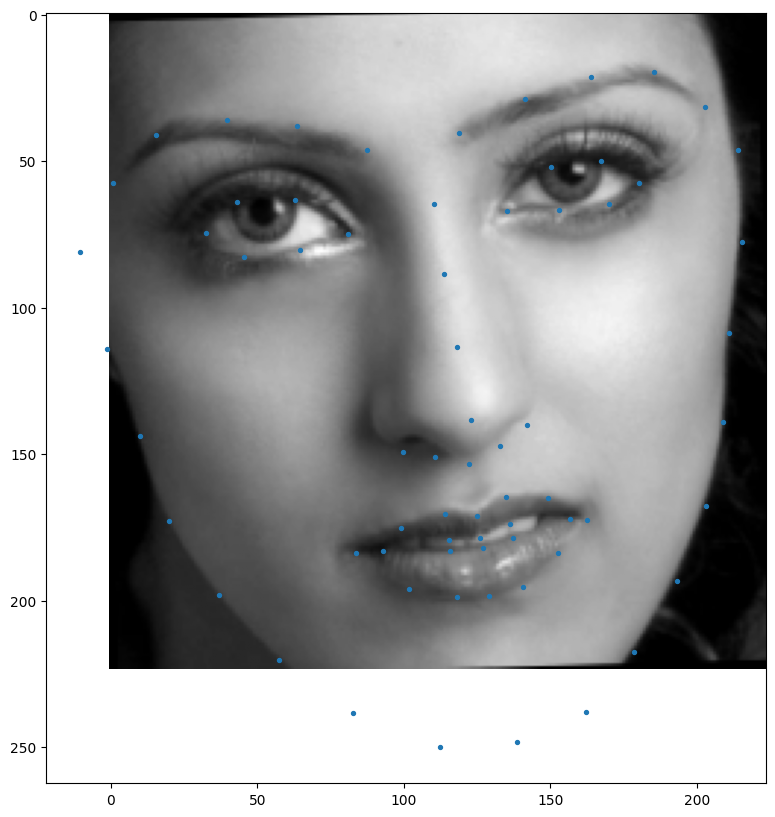

In [6]:
image, landmarks = dataset[5]
landmarks = (landmarks + 0.5) * 224
plt.figure(figsize=(10, 10))
plt.imshow(image.numpy().squeeze(), cmap='gray');
plt.scatter(landmarks[:,0], landmarks[:,1], s=8);

##Split the Dataset for Training and Prediction of Face Landmarks

In [7]:
# split the dataset into validation and test sets
len_valid_set = int(0.1*len(dataset))
len_train_set = len(dataset) - len_valid_set

print("The length of Train set is {}".format(len_train_set))
print("The length of Valid set is {}".format(len_valid_set))

train_dataset , valid_dataset,  = torch.utils.data.random_split(dataset , [len_train_set, len_valid_set])

# shuffle and batch the datasets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=8, shuffle=True, num_workers=4)

The length of Train set is 6000
The length of Valid set is 666


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


##Testing the shape of input data:

In [8]:
images, landmarks = next(iter(train_loader))

print(images.shape)
print(landmarks.shape)

<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


torch.Size([64, 1, 224, 224])
torch.Size([64, 68, 2])


##Define the Face Landmarks Detection Model


Now I will use the ResNet18 as our fundamental framework. I will modify the first and last layers so that the layers will fit easily for our purpose:

In [9]:
class Network(nn.Module):
    def __init__(self,num_classes=136):
        super().__init__()
        self.model_name='resnet18'
        self.model=models.resnet18()
        self.model.conv1=nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.model.fc=nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        x=self.model(x)
        return x

In [10]:
import sys

def print_overwrite(step, total_step, loss, operation):
    sys.stdout.write('\r')
    if operation == 'train':
        sys.stdout.write("Train Steps: %d/%d  Loss: %.4f " % (step, total_step, loss))
    else:
        sys.stdout.write("Valid Steps: %d/%d  Loss: %.4f " % (step, total_step, loss))

    sys.stdout.flush()

##Training the Neural Network for Face Landmarks Detection

I will now use the Mean Squared Error between the true and predicted face Landmarks:

In [ ]:
torch.autograd.set_detect_anomaly(True)
network = Network()
network.cuda()

criterion = nn.MSELoss()
optimizer = optim.Adam(network.parameters(), lr=0.0001)

loss_min = np.inf
num_epochs = 10

start_time = time.time()
for epoch in range(1,num_epochs+1):

    loss_train = 0
    loss_valid = 0
    running_loss = 0

    network.train()
    for step in range(1,len(train_loader)+1):

        images, landmarks = next(iter(train_loader))

        images = images.cuda()
        landmarks = landmarks.view(landmarks.size(0),-1).cuda()

        predictions = network(images)

        # clear all the gradients before calculating them
        optimizer.zero_grad()

        # find the loss for the current step
        loss_train_step = criterion(predictions, landmarks)

        # calculate the gradients
        loss_train_step.backward()

        # update the parameters
        optimizer.step()

        loss_train += loss_train_step.item()
        running_loss = loss_train/step

        print_overwrite(step, len(train_loader), running_loss, 'train')

    network.eval()
    with torch.no_grad():

        for step in range(1,len(valid_loader)+1):

            images, landmarks = next(iter(valid_loader))

            images = images.cuda()
            landmarks = landmarks.view(landmarks.size(0),-1).cuda()

            predictions = network(images)

            # find the loss for the current step
            loss_valid_step = criterion(predictions, landmarks)

            loss_valid += loss_valid_step.item()
            running_loss = loss_valid/step

            print_overwrite(step, len(valid_loader), running_loss, 'valid')

    loss_train /= len(train_loader)
    loss_valid /= len(valid_loader)

    print('\n--------------------------------------------------')
    print('Epoch: {}  Train Loss: {:.4f}  Valid Loss: {:.4f}'.format(epoch, loss_train, loss_valid))
    print('--------------------------------------------------')

    if loss_valid < loss_min:
        loss_min = loss_valid
        torch.save(network.state_dict(), '/content/face_landmarks.pth')
        print("\nMinimum Validation Loss of {:.4f} at epoch {}/{}".format(loss_min, epoch, num_epochs))
        print('Model Saved\n')
print('Training Complete')
print("Total Elapsed Time : {} s".format(time.time()-start_time))

<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 1/94  Loss: 0.3070 

<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 2/94  Loss: 0.2760 

<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 3/94  Loss: 0.2513 

<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 4/94  Loss: 0.2290 

<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 5/94  Loss: 0.2085 

<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 6/94  Loss: 0.1905 

<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 7/94  Loss: 0.1744 

<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 8/94  Loss: 0.1602 

<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 9/94  Loss: 0.1476 

<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 10/94  Loss: 0.1366 

<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 11/94  Loss: 0.1271 

<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 12/94  Loss: 0.1187 

<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 13/94  Loss: 0.1113 

<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 14/94  Loss: 0.1047 

<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 15/94  Loss: 0.0989 

<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 16/94  Loss: 0.0937 

<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 17/94  Loss: 0.0890 

<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 18/94  Loss: 0.0849 

<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 19/94  Loss: 0.0811 

<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 20/94  Loss: 0.0777 

<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 21/94  Loss: 0.0746 

<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 22/94  Loss: 0.0718 

<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 23/94  Loss: 0.0692 

<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 24/94  Loss: 0.0668 

<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 25/94  Loss: 0.0646 

<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 26/94  Loss: 0.0625 

<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 27/94  Loss: 0.0605 

<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 28/94  Loss: 0.0587 

<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 29/94  Loss: 0.0570 

<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 30/94  Loss: 0.0555 

<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 31/94  Loss: 0.0540 

<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 32/94  Loss: 0.0526 

<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 33/94  Loss: 0.0513 

<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 34/94  Loss: 0.0500 

<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 35/94  Loss: 0.0489 

<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 36/94  Loss: 0.0477 

<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 37/94  Loss: 0.0467 

<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 38/94  Loss: 0.0456 

<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 39/94  Loss: 0.0447 

<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 40/94  Loss: 0.0438 

<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 41/94  Loss: 0.0429 

<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 42/94  Loss: 0.0421 

<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 43/94  Loss: 0.0413 

<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 44/94  Loss: 0.0405 

<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 45/94  Loss: 0.0397 

<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 46/94  Loss: 0.0391 

<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 47/94  Loss: 0.0384 

<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 48/94  Loss: 0.0377 

<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 49/94  Loss: 0.0371 

<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 50/94  Loss: 0.0365 

<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 51/94  Loss: 0.0360 

<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 52/94  Loss: 0.0354 

<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 53/94  Loss: 0.0349 

<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 54/94  Loss: 0.0344 

<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 55/94  Loss: 0.0339 

<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 56/94  Loss: 0.0334 

<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 57/94  Loss: 0.0330 

<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 58/94  Loss: 0.0325 

<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 59/94  Loss: 0.0321 

<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 60/94  Loss: 0.0317 

<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 61/94  Loss: 0.0313 

<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 62/94  Loss: 0.0309 

<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 63/94  Loss: 0.0305 

<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 64/94  Loss: 0.0301 

<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 65/94  Loss: 0.0298 

<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 66/94  Loss: 0.0294 

<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Train Steps: 67/94  Loss: 0.0291 

<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


##Face Landmarks Prediction

Now let’s use the model that we trained above on the unseen images in the dataset:

<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)
<ipython-input-4-1896a3675aab>:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Total number of test images: 666
Elapsed Time : 2.348625659942627


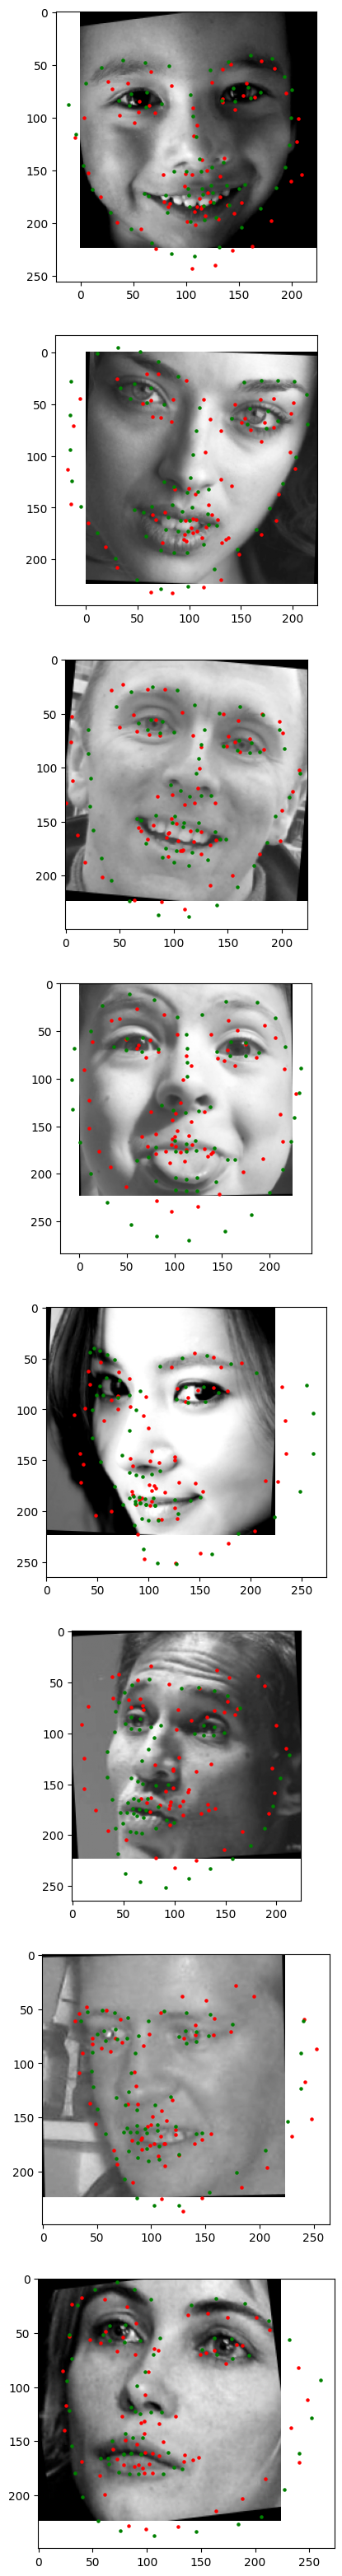

In [ ]:
start_time = time.time()

with torch.no_grad():

    best_network = Network()
    best_network.cuda()
    best_network.load_state_dict(torch.load('/content/face_landmarks.pth'))
    best_network.eval()

    images, landmarks = next(iter(valid_loader))

    images = images.cuda()
    landmarks = (landmarks + 0.5) * 224

    predictions = (best_network(images).cpu() + 0.5) * 224
    predictions = predictions.view(-1,68,2)

    plt.figure(figsize=(10,40))

    for img_num in range(8):
        plt.subplot(8,1,img_num+1)
        plt.imshow(images[img_num].cpu().numpy().transpose(1,2,0).squeeze(), cmap='gray')
        plt.scatter(predictions[img_num,:,0], predictions[img_num,:,1], c = 'r', s = 5)
        plt.scatter(landmarks[img_num,:,0], landmarks[img_num,:,1], c = 'g', s = 5)

print('Total number of test images: {}'.format(len(valid_dataset)))

end_time = time.time()
print("Elapsed Time : {}".format(end_time - start_time))

## TEST on reel time video

In [ ]:
import cv2
import torch
import numpy as np
from PIL import Image
import torchvision.transforms.functional as TF


# Charger le modèle pré-entraîné
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Network().to(device)
model.load_state_dict(torch.load('/content/face_landmarks.pth', map_location=device))
model.eval()

# Détecteur de visages (pour localiser le visage avant d'appliquer le modèle)
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Capture vidéo
cap = cv2.VideoCapture(0)  # 0 pour la webcam par défaut

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Convertir en niveaux de gris pour la détection de visage
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Détection des visages
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    for (x, y, w, h) in faces:
        # Extraire la région du visage
        face_roi = gray[y:y+h, x:x+w]

        # Préparation de l'image pour le modèle
        face_pil = Image.fromarray(face_roi)
        face_tensor = TF.to_tensor(face_pil).unsqueeze(0).to(device)
        face_tensor = TF.normalize(face_tensor, [0.5], [0.5])

        # Prédiction des landmarks
        with torch.no_grad():
            landmarks = (model(face_tensor).cpu().numpy() + 0.5) * 224
            landmarks = landmarks.reshape(-1, 2)

        # Redimensionner les landmarks à la taille originale du visage
        landmarks[:, 0] = landmarks[:, 0] * (w / 224) + x
        landmarks[:, 1] = landmarks[:, 1] * (h / 224) + y

        # Dessiner les landmarks sur l'image originale
        for (lx, ly) in landmarks:
            cv2.circle(frame, (int(lx), int(ly)), 2, (0, 255, 0), -1)

        # Dessiner le rectangle autour du visage
        cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)

    # Afficher le résultat
    cv2.imshow('Face Landmarks', frame)

    # Quitter avec la touche 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()